### Build your own

Let's start by first building out own word2vec model, instead of downloading a ready trained one. For that we are going to use the 20 news groups from sklearn, since is not too large for a lab exercise.

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

# lets check the first two documents
documents[:2]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

The first thing to do is to format the documents into a list of sentences that contains a list of tokens. We are not going to do any further cleaning and pre-processing for now (to keep things simple for the labs), but that would be advisable.

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize

# This will take a minute or so
token_list = []
for d in documents:
    s = sent_tokenize(d) 
    token_list = token_list +[word_tokenize(t) for t in s]

# check the first three sentences
token_list[:3]

[['Well',
  'i',
  "'m",
  'not',
  'sure',
  'about',
  'the',
  'story',
  'nad',
  'it',
  'did',
  'seem',
  'biased',
  '.'],
 ['What',
  'I',
  'disagree',
  'with',
  'is',
  'your',
  'statement',
  'that',
  'the',
  'U.S.',
  'Media',
  'is',
  'out',
  'to',
  'ruin',
  'Israels',
  'reputation',
  '.'],
 ['That', 'is', 'rediculous', '.']]

Now is time to import the word2vec algorithm and set the key parameters

In [6]:
from gensim.models.word2vec import Word2Vec

# Number of vector elements (dimensions) to represent the word vector
num_features = 300
# Min number of word count to be considered in the Word2vec model. If your corpus is small, reduce the min count. If you’re training with a large corpus, increase the min count.
min_word_count = 1
# Number of CPU cores used for the training. If you want to set the number of cores dynamically, check out import multiprocessing: 
#num_workers = multiprocessing.cpu_count()
num_workers = 2
# Context window size
window_size = 3
# Subsampling rate for frequent terms
subsampling = 1e-3

Let's train the model!

In [7]:
%%time
model = Word2Vec(token_list, workers=num_workers, min_count=min_word_count, window=window_size, sample=subsampling)

CPU times: user 34.1 s, sys: 392 ms, total: 34.5 s
Wall time: 18.9 s


Once you’ve trained your word model, you can reduce the memory footprint by about half if you freeze your model and discard the unnecessary information. The following command will discard the unneeded output weights of your neural network:

In [8]:
model.init_sims(replace=True)

/tmp/ipykernel_718/1992334471.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


The model cannot be trained further once the weights of the output layer have been discarded.

Save the trained model with the following command and preserve it for later use:

In [9]:
model_name = "my_own_domain_specific_word2vec_model"
model.save(model_name)

Now lets say we want to load the model that we had previously saved.

In [10]:
from gensim.models.word2vec import Word2Vec
model_name = "my_own_domain_specific_word2vec_model"
model = Word2Vec.load(model_name)

Let's check the most similar words to "justice"

In [11]:
print(model.wv.most_similar('justice'))

[('physics', 0.8776096701622009), ('race', 0.8758638501167297), ('democracy', 0.8747128248214722), ('rationality', 0.8669155240058899), ('Judaism', 0.8640549778938293), ('hatred', 0.8633760213851929), ('murder', 0.8608945608139038), ('banning', 0.8592671155929565), ('blind', 0.858574390411377), ('hostility', 0.8581688404083252)]


# Challenge - 1

Try a few more words and observe if what is retrieved makes sense

In [15]:
print(model.wv.most_similar('law'))

[('government', 0.8822431564331055), ('state', 0.8582978248596191), ('laws', 0.8493106365203857), ('military', 0.8262790441513062), ('crime', 0.8257684707641602), ('rights', 0.818207859992981), ('legal', 0.8179803490638733), ('individual', 0.8175240755081177), ('gun', 0.8096334338188171), ('human', 0.8051594495773315)]


In [17]:
print(model.wv.most_similar('fear'))

[('practice', 0.9158351421356201), ('worship', 0.8910408020019531), ('talent', 0.8785630464553833), ('flesh', 0.8784859776496887), ('murder', 0.8685800433158875), ('food', 0.8645903468132019), ('respect', 0.8645899891853333), ('society', 0.8638277053833008), ('sin', 0.8631774187088013), ('battle', 0.8585665225982666)]


### Using the gensim API

Having build our own model is great, but let's now load a model that was trained with MANY documents.


In [18]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

We will be using the downloader for the embedding models

In [19]:
import gensim.downloader as api

#this command can be used to check what models are available
#api.info()

Let's load the word2vec model from google news containing 300 features

In [20]:
# This will also take a minute or so
word2vec_model = api.load('word2vec-google-news-300')

Now check the embedding vector for "beautiful"... you will see a 300 dimensional vector

In [21]:
word2vec_model["beautiful"]

array([-0.01831055,  0.05566406, -0.01153564,  0.07275391,  0.15136719,
       -0.06176758,  0.20605469, -0.15332031, -0.05908203,  0.22851562,
       -0.06445312, -0.22851562, -0.09472656, -0.03344727,  0.24707031,
        0.05541992, -0.00921631,  0.1328125 , -0.15429688,  0.08105469,
       -0.07373047,  0.24316406,  0.12353516, -0.09277344,  0.08203125,
        0.06494141,  0.15722656,  0.11279297, -0.0612793 , -0.296875  ,
       -0.13378906,  0.234375  ,  0.09765625,  0.17773438,  0.06689453,
       -0.27539062,  0.06445312, -0.13867188, -0.08886719,  0.171875  ,
        0.07861328, -0.10058594,  0.23925781,  0.03808594,  0.18652344,
       -0.11279297,  0.22558594,  0.10986328, -0.11865234,  0.02026367,
        0.11376953,  0.09570312,  0.29492188,  0.08251953, -0.05444336,
       -0.0090332 , -0.0625    , -0.17578125, -0.08154297,  0.01062012,
       -0.04736328, -0.08544922, -0.19042969, -0.30273438,  0.07617188,
        0.125     , -0.05932617,  0.03833008, -0.03564453,  0.24

Let's check some similar words to the word "girl"

In [22]:
word2vec_model.most_similar("girl")

[('boy', 0.8543271422386169),
 ('teenage_girl', 0.7927975654602051),
 ('woman', 0.7494640946388245),
 ('teenager', 0.7172499299049377),
 ('schoolgirl', 0.7075953483581543),
 ('teenaged_girl', 0.6650916337966919),
 ('daughter', 0.6489864587783813),
 ('mother', 0.6478164196014404),
 ('toddler', 0.6473966836929321),
 ('girls', 0.6154742240905762)]

How about some maths with vectors! Try the following:

queen - girl + boy = king

In [24]:
word2vec_model.most_similar(positive=['boy', 'queen'], negative=['girl'], topn=1)

[('king', 0.7298421859741211)]

Time to do some visualisations and see how similar words end up close together and far from other words that are not as similar

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


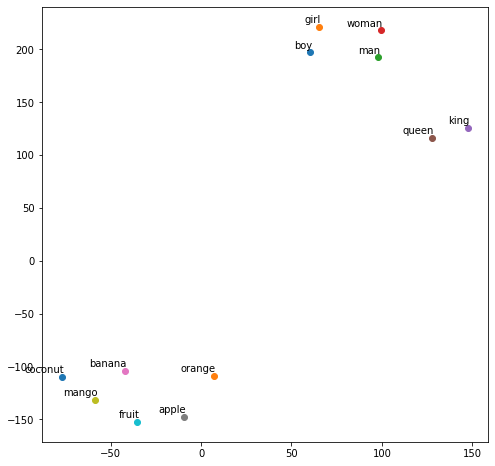

In [26]:
vocab = ["boy", "girl", "man", "woman", "king", "queen", "banana", "apple", "mango", "fruit", "coconut", "orange"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(word2vec_model)

# Challenge - 2

Try a few more examples to visualise and see if similar words land close together

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


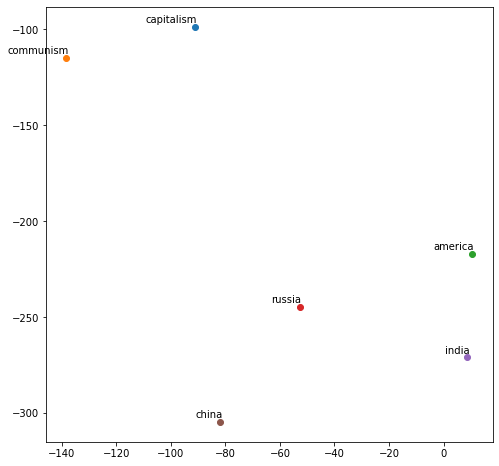

In [27]:
vocab = ["capitalism", "communism", "america", "russia", "india", "china"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(word2vec_model)

---
---
# GloVe

Let's try another model (GloVe) and see if that is any different to word2vec


In [28]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [29]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-300')

In [30]:
glove_model["beautiful"]

array([-2.3852e-01, -3.3704e-01, -2.6531e-01, -3.4693e-01, -1.2875e-01,
        1.0698e-01, -2.4669e-02,  2.6829e-02, -1.0024e-01, -9.1494e-01,
        4.8989e-01, -1.0362e-01, -2.4535e-01,  5.7003e-01, -3.5189e-02,
       -3.7690e-01, -6.9177e-02, -2.5942e-01,  2.2511e-01,  5.1855e-01,
       -3.9326e-01,  1.2665e+00, -4.4396e-01,  7.6827e-01, -1.0909e-02,
       -2.4237e-01, -1.0275e-01, -4.9712e-01, -8.0183e-02,  4.0611e-01,
        2.1275e-01,  6.5182e-01, -1.1487e+00,  4.6080e-03, -6.8265e-01,
        9.6941e-01, -7.6194e-02, -4.1590e-01, -2.7069e-01, -5.3364e-02,
       -7.9631e-02, -2.6670e-01, -2.1544e-02,  2.2392e-01,  5.5741e-02,
        8.4611e-02,  8.6011e-01,  4.8927e-01,  4.7428e-01, -2.4446e-01,
       -2.1553e-01,  1.4370e-01,  5.0683e-01, -5.8435e-01, -5.6243e-01,
       -6.3757e-02, -2.2861e-01, -6.9374e-02,  5.6618e-01, -8.7813e-02,
       -2.1272e-01, -1.6319e-01,  3.3545e-01,  1.3707e-01, -1.1920e-03,
        9.7461e-02,  3.2382e-01, -2.2693e-01, -1.7767e-01,  4.01

It will be interesting to see if this will fins similar words to "girl" like word2vec did

In [31]:
glove_model.most_similar("girl")

[('boy', 0.8272891044616699),
 ('woman', 0.729641854763031),
 ('girls', 0.7227292060852051),
 ('teenager', 0.6509774327278137),
 ('teenage', 0.6492719054222107),
 ('mother', 0.6417974829673767),
 ('boys', 0.6283578872680664),
 ('child', 0.6229295134544373),
 ('teen', 0.612524151802063),
 ('daughter', 0.6050207614898682)]

Let's also see if it can solve the same analogy too..

In [32]:
glove_model.most_similar(positive=['boy', 'queen'], negative=['girl'], topn=1)

[('king', 0.6770139932632446)]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


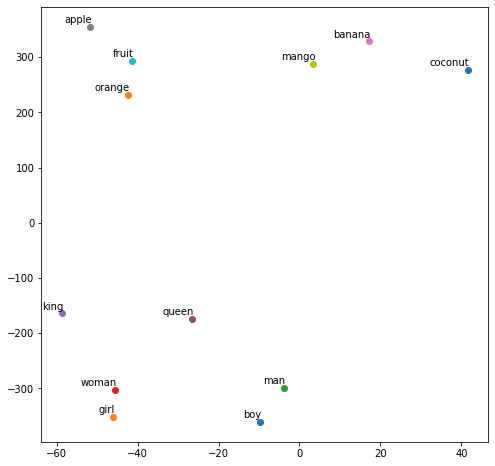

In [33]:
vocab = ["boy", "girl", "man", "woman", "king", "queen", "banana", "apple", "mango", "fruit", "coconut", "orange"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(glove_model)

Let's continue with GloVe and check if plural words play any role in how close is to the original singular words

In [34]:
print(glove_model.distance("fruit", "fruits"))
print(glove_model.distance("girl", "girls"))
print(glove_model.distance("girl", "boy"))

0.17594563961029053
0.2772707939147949
0.17271089553833008


# Challenge - 3

Calculate the distance for "king" and "queen", then for "woman and "man". Is it similar? Check the plot to confirm.

In [35]:
print(glove_model.distance("king", "queen"))
print(glove_model.distance("woman", "man"))

0.3663531541824341
0.30013370513916016


We find that it is similar!

Calculate the distance for "king" and "apple", then for "queen" and "apple". Is it similar again? Check the plot to confirm.

In [36]:
print(glove_model.distance("king", "apple"))
print(glove_model.distance("queen", "apple"))

0.8534674644470215
0.8454712331295013


We observe that this is very close too!

Now let's try and see if the model can find the capitals of different countries

In [37]:
import pandas as pd
# pretty print function
def pp(obj):
    print(pd.DataFrame(obj))
    
def analogy(worda, wordb, wordc):
    result = glove_model.most_similar(negative=[worda], positive=[wordb, wordc], topn=1)
    return result[0][0]

countries = ['australia', 'canada', 'germany', 'ireland', 'italy', 'india']
capitals = [analogy('usa', 'washington', country) for country in countries]
pp(zip(countries,capitals))

           0         1
0  australia  canberra
1     canada    ottawa
2    germany    berlin
3    ireland    dublin
4      italy      rome
5      india     delhi


# Challenge - 4

Looks good... but what if you change "usa" to "us"? Or if you used a different example to start with like "greece" and "athens"?

Now let's plot the results on a graph


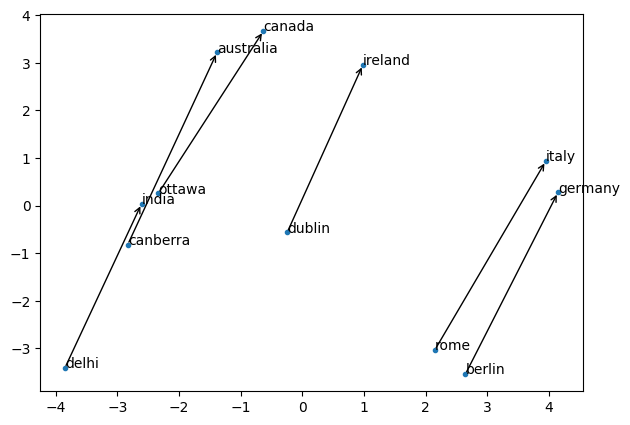

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_data(orig_data, labels):
    pca = PCA(n_components=2)
    data = pca.fit_transform(orig_data)
    plt.figure(figsize=(7, 5), dpi=100)
    plt.plot(data[:,0], data[:,1], '.')
    for i in range(len(data)):
        plt.annotate(labels[i], xy = data[i])
    for i in range(len(data)//2):
        plt.annotate("",
                xy=data[i],
                xytext=data[i+len(data)//2],
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3")
        )
       
labels = countries + capitals
data = [glove_model[w] for w in labels]
plot_data(data, labels)

## doc2vec

Now let's look into generating feature vectors for documents instead of just words. For that we are going to use word2vec


In [39]:
import multiprocessing
num_cores = multiprocessing.cpu_count()

from gensim.models.doc2vec import TaggedDocument,Doc2Vec
from gensim.utils import simple_preprocess

First let's load some data

In [40]:
corpus = ['This is the first document','another document']

training_corpus = []
for i, text in enumerate(corpus):
    tagged_doc = TaggedDocument(simple_preprocess(text), [i])
    training_corpus.append(tagged_doc)
    
# If you’re running low on RAM, and you know the number of documents ahead of time (your corpus object isn’t an iterator or generator),
# you might want to use a preallocated numpy array instead of Python list for your training_corpus:
#training_corpus = np.empty(len(corpus), dtype=object);
#… 
#training_corpus[i] = …

Now we will build the model and train it

In [41]:
doc2vec_model = Doc2Vec(vector_size=100, min_count=2, workers=num_cores, epochs=10)
doc2vec_model.build_vocab(training_corpus)
doc2vec_model.train(training_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

Time to generate the feature vector of a new document!

In [42]:
doc2vec_model.infer_vector(simple_preprocess('This is a completely unseen document'))

array([ 2.9114562e-03,  4.0727728e-03, -1.0241866e-05, -2.7959300e-03,
       -4.0431363e-03, -2.9323227e-03,  2.6867532e-03,  3.7330680e-03,
       -1.0716557e-04, -3.2240767e-03, -4.7925287e-03, -2.7302862e-04,
       -1.4193022e-03,  6.1527669e-04, -3.8702092e-03,  1.8032825e-03,
        1.2906969e-03, -4.8076170e-03,  2.7846384e-03, -3.4752244e-03,
        3.5910343e-03,  3.5919268e-03, -3.4258622e-03, -3.9172126e-03,
       -3.4930318e-04, -3.6265301e-03, -2.3045198e-03,  2.4252499e-03,
        1.2968314e-03, -3.7890309e-03, -4.2944383e-03,  1.0544044e-03,
        2.3632317e-03, -4.3948758e-03, -3.8165539e-03, -4.4214129e-04,
        2.3442095e-03,  6.3376664e-04,  2.3815781e-03,  3.6897403e-03,
       -6.8105193e-04, -1.8970823e-03,  2.4375140e-03, -3.7601853e-03,
        3.2949150e-03, -3.8474528e-03,  2.8622150e-03, -3.3105034e-03,
       -4.9886452e-03,  3.1725288e-04,  3.4030706e-03,  4.8582314e-04,
        5.9340539e-04,  2.4867235e-04,  3.2324134e-04,  1.0205037e-03,
      

# Challenge - 5

Use the fetch_20newsgroups dataset from sklearn (see code above) and re-train doc2vec with that data instead.

Then, check using the most similar function to see if the documents you test are indeed similar.


In [43]:
!pip install --upgrade "sagemaker>=2"

In [44]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
corpus = dataset.data

training_corpus = []
for i, text in enumerate(corpus):
    tagged_doc = TaggedDocument(simple_preprocess(text), [i])
    training_corpus.append(tagged_doc)

In [65]:
doc2vec_model = Doc2Vec(vector_size=100, min_count=2, workers=num_cores, epochs=10)
doc2vec_model.build_vocab(training_corpus)
doc2vec_model.train(training_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [68]:
tokens = "I'm not sure about the story.".split()

new_vector = doc2vec_model.infer_vector(tokens)

In [69]:
doc2vec_model.dv.most_similar(new_vector)

[(4308, 0.8805052042007446),
 (11211, 0.8710089325904846),
 (12, 0.8585871458053589),
 (7899, 0.8541130423545837),
 (11204, 0.8514305353164673),
 (3800, 0.850949227809906),
 (3830, 0.8481282591819763),
 (1856, 0.8474627733230591),
 (1287, 0.8457885384559631),
 (4170, 0.8456740975379944)]

We observe a list of sentences from the fetch_20newsgroups dataset whose tag number and probability of match are 